<a href="https://colab.research.google.com/github/HuyenNguyenHelen/INFO-5505---Machine-learning/blob/main/HuyenNguyen_Assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 6: Image Classification with Convolutional Neural Network
Dataset: [Intel Image Classification dataset](https://www.kaggle.com/puneet6060/intel-image-classification/data#)

Goal: Classify images into 6 categories: building, forest, glacier, mountain, sea, and street.

In [7]:
# Import essential libraries
import tensorflow as tf
import timeit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob as gb 
import matplotlib.pyplot as plt
import cv2
import os, random
import seaborn as sns
from keras.preprocessing import image
import sklearn


In [8]:
# Checking the GPU installed
# %tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Loading data from Kaggle

In [9]:
# Install Kaggle library
!pip install -q kaggle

# Loading kaggle API key file
!cd ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [10]:
# Downloading the dataset from Kaggle
!kaggle datasets download -d puneet6060/intel-image-classification

# Unzipping the dataset
!unzip intel-image-classification.zip


Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

# Exploring Data

In [11]:
# Directory paths
train_path = '/content/seg_train/seg_train'
test_path = '/content/seg_test/seg_test'
pred_path = '/content/seg_pred/seg_pred'

In [12]:
os.listdir(train_path)

['sea', 'buildings', 'forest', 'mountain', 'street', 'glacier']

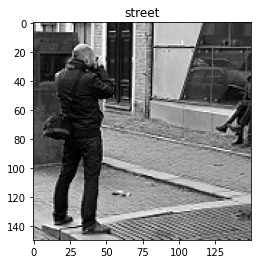

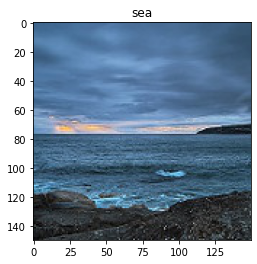

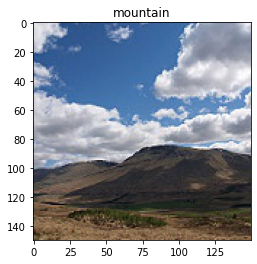

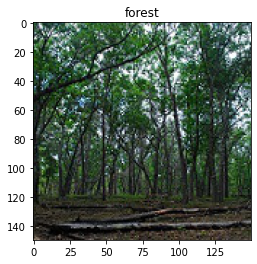

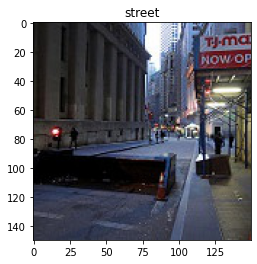

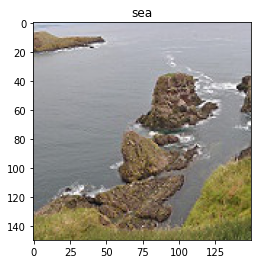

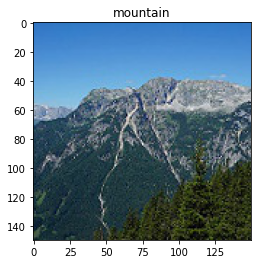

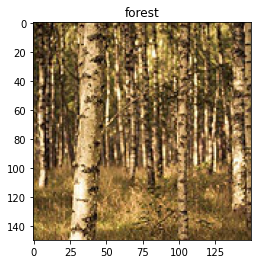

In [13]:
# Showing some images to observe
def show_pictures(path,class_):
    selected_fpath = random.choice(gb.glob(pathname = path+ '/'+ class_+'/*.jpg'))
    img = image.load_img(selected_fpath, target_size=(150, 150))
    ## Encoding image into integer in the 0–255 range
    image_tensor = image.img_to_array(img)  
    # Nomalizing the pixel in [0, 1]
    image_tensor /= 255 
    plt.imshow(image_tensor)
    plt.title(class_)
    plt.show()

for i in range(0,2):
    show_pictures(train_path, 'street')
    show_pictures(train_path, 'sea')
    show_pictures(test_path, 'mountain')
    show_pictures(test_path, 'forest')
plt.show()

In [14]:
# Exploring sizes of the training, testing and prediction sets
def exploring_size (path):
  size =0
  try:
    for name in os.listdir(path):
      size += len(os.listdir(path + '/' + name))
  except:
    size += len(os.listdir(path))
  return size

print('The number of images in the training set: ', exploring_size(train_path))
print('The number of images in the test set: ', exploring_size(test_path))
print('The number of images in the prediction set: ', exploring_size(pred_path))

The number of images in the training set:  14034
The number of images in the test set:  3000
The number of images in the prediction set:  7301


In [15]:
# Exploring data's labels 
folder_names = os.listdir(train_path)
print('All labels: ', folder_names)

# Exploring data distribution in the training set
print ('-'*30, '\nData distributed in the training set:')
for name in folder_names:
  print (name, ': ', len(os.listdir(train_path + '/' + name)))

# Exploring data distributed in the test set
print ('-'*30, '\nData distributed in the test set:')
for name in folder_names:
  print (name, ': ', len(os.listdir(test_path + '/' + name)))

All labels:  ['sea', 'buildings', 'forest', 'mountain', 'street', 'glacier']
------------------------------ 
Data distributed in the training set:
sea :  2274
buildings :  2191
forest :  2271
mountain :  2512
street :  2382
glacier :  2404
------------------------------ 
Data distributed in the test set:
sea :  510
buildings :  437
forest :  474
mountain :  525
street :  501
glacier :  553


In [16]:
# Adding a distribution graph

In [17]:
# Exploring the images' sizes
def explore_image_size (path):
  size = []
  for name in os.listdir(path):
    file_paths = gb.glob(pathname = path+ '/'+ name+'/*.jpg')
    for p in file_paths:
      size.append(plt.imread(p).shape)
  return pd.DataFrame(size, columns = ['H', 'W', 'D']).value_counts()
  
print('Image sizes in the training set\n',  explore_image_size (train_path))
print('\nImage sizes in the test set\n',  explore_image_size (test_path))


Image sizes in the training set
 H    W    D
150  150  3    13986
113  150  3        7
135  150  3        3
111  150  3        3
144  150  3        2
143  150  3        2
142  150  3        2
146  150  3        2
136  150  3        2
134  150  3        2
108  150  3        2
123  150  3        2
97   150  3        1
100  150  3        1
81   150  3        1
103  150  3        1
105  150  3        1
110  150  3        1
102  150  3        1
124  150  3        1
115  150  3        1
119  150  3        1
120  150  3        1
149  150  3        1
131  150  3        1
133  150  3        1
140  150  3        1
141  150  3        1
145  150  3        1
147  150  3        1
76   150  3        1
dtype: int64

Image sizes in the test set
 H    W    D
150  150  3    2993
149  150  3       1
141  150  3       1
131  150  3       1
110  150  3       1
81   150  3       1
76   150  3       1
72   150  3       1
dtype: int64


We can see  that most images have the size 150x150x3. It's reasonable to resize all images to this size. However, we want to reduce all images into a size of 64x64x3 to reduce training time. 

# Data Preprocessing
For data processing, we would like to rescale our images so that every image's pixel value ranges between 0 and 1.
Futher, we should apply data augmentation since our dataset is not large. Data Augmentation is a wise way to inc....for the training set that can help the model avoid overfitting. Some data augmentations we could use are rotating images with some random angles. 

In [18]:
# Encoding data labels
encoded_labels = dict()
for v, k in enumerate(folder_names):
  encoded_labels[k]=v  
print('labels encoded:', encoded_labels)



labels encoded: {'sea': 0, 'buildings': 1, 'forest': 2, 'mountain': 3, 'street': 4, 'glacier': 5}


In [19]:
# Getting images and labels stored in two list
# And resizing images
def resize_image_xy (path):
  X, y = [],[]
  for name in os.listdir(path):
    file_paths = gb.glob(pathname = path+ '/'+ name+'/*.jpg')
    for p in file_paths:
      image = plt.imread(p)
      resized_image = cv2.resize(image,(64,64) )
      X.append(resized_image)
      y.append(encoded_labels[name])
  return X, y

def resize_image_x (path):
  X = []
  for name in os.listdir(path):
    path_file = path+'/'+ name
    image = plt.imread(path_file)
    resized_image = cv2.resize(image,(64,64) )
    X.append(resized_image)
  return X

# For images in the training set
X_train, y_train = resize_image_xy (train_path)
print('The number of images in the training set:', len(X_train), len(y_train))

# For images in the test set
X_test, y_test = resize_image_xy (test_path)
print('The number of images in the testing set:', len(X_test), len(y_test))

#For images in the predicting set
X_pred = resize_image_x (pred_path)
print('The number of images in the predicting set:', len(X_pred))


The number of images in the training set: 14034 14034
The number of images in the testing set: 3000 3000
The number of images in the predicting set: 7301


In [20]:
# Converting data into arrays, and shuffling them before splitting for K-fold cross validation
from sklearn.utils import shuffle
X_train, y_train = sklearn.utils.shuffle(np.array(X_train), np.array(y_train), random_state = 42)
X_test, y_test = sklearn.utils.shuffle(np.array(X_test), np.array(y_test))
X_pred = np.array(X_pred)
print('The shape of X_train:', X_train.shape)
print('The shape of y_train:', y_train.shape)
print('The shape of X_test:', X_test.shape)
print('The shape of y_test:', y_test.shape)
print('The shape of X_pred:', X_pred.shape)

The shape of X_train: (14034, 64, 64, 3)
The shape of y_train: (14034,)
The shape of X_test: (3000, 64, 64, 3)
The shape of y_test: (3000,)
The shape of X_pred: (7301, 64, 64, 3)


# Building a base CNN model

In [21]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten

# Defining a CNN model
def define_cnn():
  # Creating the model
  cnn = Sequential()

  # Convolution 1
  cnn.add(Conv2D(32, (3,3), activation='relu', input_shape = (64,64,3)))
  # Maxpooling 1
  cnn.add(MaxPooling2D(pool_size = (2,2)))

  # Convolution 2
  cnn.add(Conv2D(64, (3,3), activation = 'relu'))
  # Maxpooling 2
  cnn.add(MaxPooling2D(pool_size = (2,2)))

  # Convolution 3
  cnn.add(Conv2D(64, (3,3), activation = 'relu'))
  #  Maxpooling 3
  cnn.add(MaxPooling2D(pool_size = (2,2)))

  # Flatten
  cnn.add(Flatten())
  
  # Fully-connected NN layer
  cnn.add(Dense(32, activation = 'relu'))
  cnn.add(Dense(16, activation = 'relu'))
  cnn.add(Dense(6, activation = 'softmax'))
  return cnn



In [22]:
# Creating generator models for preprocessing and data agmentation
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(rescale = 1./255,    
                                      shear_range = 0.2,
                                      rotation_range=20,
                                      zoom_range = 0.2,
                                      horizontal_flip = True)
test_generator = ImageDataGenerator(rescale = 1./255)

# Defining 10-fold cross validation for validating the model in the training set
kfold = KFold(n_splits = 10, shuffle = True)
fold_accuracy = []
fold_loss = []
fold = 1

for train, test in kfold.split(np.zeros(len(y_train)),y_train): ## kfold.split just splitting the data indices into fold, so we can use np.zero for getting the indices
  ## Applying the data generator models to process data 
  train_generated = train_generator.flow(X_train[train], y_train[train], batch_size=32)
  test_generated = test_generator.flow(X_train[test], y_train[test], batch_size=32)
  
  ## Creating the cnn model
  cnn = define_cnn()
  
  ## Compiling the model
  cnn.compile(optimizer = 'adam', 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics = ['accuracy'])
  print ('-'*35, '\nTraining on fold {}'.format(fold))

  ## Fitting the model into the training set
  history = cnn.fit(train_generated,  
                    epochs = 5,
                    validation_data=(test_generated) )
  
  ## Creating validation metrics
  scores = cnn.evaluate(test_generated, verbose=1)
  print(f"Score of fold: {fold}: {cnn.metrics_names[0]} is {scores[0]}, {cnn.metrics_names[1]} is {scores[1]}")
  
  ## Getting loss and accuracy scores of all folds
  fold_loss.append(scores[0])
  fold_accuracy.append(scores[1])
  fold += 1

# Printing the average scores of 10 folders to get the generalized scores of the model
print('-'*35)
print('The generalized scores of the model:')
print('Accuracy: ', np.mean(fold_accuracy))
print('Loss: ', np.mean(fold_loss))


----------------------------------- 
Training on fold 1
Epoch 1/5
395/395 [==============================] - 47s 38ms/step - loss: 1.5196 - accuracy: 0.3901 - val_loss: 1.0504 - val_accuracy: 0.6004
Epoch 2/5
395/395 [==============================] - 14s 37ms/step - loss: 1.0320 - accuracy: 0.6000 - val_loss: 1.0385 - val_accuracy: 0.6197
Epoch 3/5
395/395 [==============================] - 14s 36ms/step - loss: 0.9227 - accuracy: 0.6507 - val_loss: 0.8647 - val_accuracy: 0.6944
Epoch 4/5
395/395 [==============================] - 14s 36ms/step - loss: 0.8196 - accuracy: 0.6967 - val_loss: 0.7902 - val_accuracy: 0.7279
Epoch 5/5
44/44 [==============================] - 0s 4ms/step - loss: 0.7373 - accuracy: 0.7472
Score of fold: 1: loss is 0.7373268008232117, accuracy is 0.7471510171890259
----------------------------------- 
Training on fold 2
Epoch 1/5
395/395 [==============================] - 15s 36ms/step - loss: 1.4198 - accuracy: 0.4093 - val_loss: 0.9494 - val_accuracy: 0.6268

In [23]:
# Preprocessing the train and test data with data generator models created before
train_generated = train_generator.flow(X_train, y_train, batch_size=32)
test_generated = test_generator.flow(X_test, y_test, batch_size=32, shuffle=False)


In [24]:
# Fitting the model in the whole training set
cnn.fit(train_generated, epochs = 5,  verbose = 1)
model_loss, model_accuracy = cnn.evaluate(test_generated)
print(cnn.summary())
print(model_loss, model_accuracy)

Epoch 1/5
439/439 [==============================] - 16s 36ms/step - loss: 0.7017 - accuracy: 0.7462
Epoch 2/5
439/439 [==============================] - 16s 36ms/step - loss: 0.6588 - accuracy: 0.7561
Epoch 3/5
439/439 [==============================] - 16s 36ms/step - loss: 0.6299 - accuracy: 0.7717
Epoch 4/5
439/439 [==============================] - 16s 35ms/step - loss: 0.5963 - accuracy: 0.7829
Epoch 5/5
94/94 [==============================] - 0s 5ms/step - loss: 0.5604 - accuracy: 0.8043
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 29, 29, 64)        18496     
_______________

In [25]:
from sklearn.metrics import confusion_matrix, classification_report

# Applying the model to predict on the test set
y_test_pred = np.argmax(cnn.predict(test_generated), axis=-1) 
labels = [label for label in encoded_labels.keys() ]
# Printing class
print(classification_report(y_test, y_test_pred,  target_names=labels))


              precision    recall  f1-score   support

         sea       0.82      0.74      0.78       510
   buildings       0.76      0.76      0.76       437
      forest       0.88      0.97      0.92       474
    mountain       0.80      0.74      0.77       525
      street       0.79      0.87      0.83       501
     glacier       0.76      0.76      0.76       553

    accuracy                           0.80      3000
   macro avg       0.80      0.81      0.80      3000
weighted avg       0.80      0.80      0.80      3000



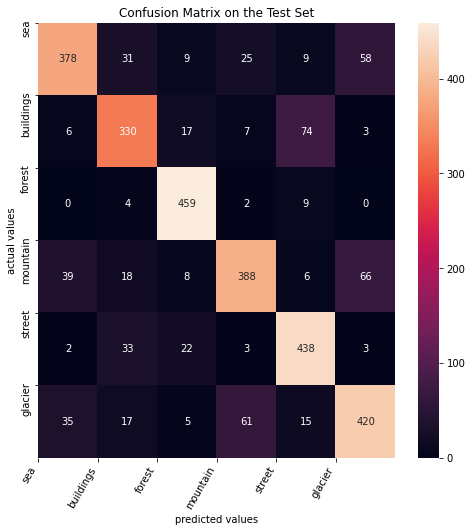

In [26]:
# Evaluating the model with confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
## Visualizing the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(conf_matrix, annot = True, fmt=".0f" )
plt.xticks(np.arange(6), labels, rotation = 60, ha='right' )
plt.yticks(np.arange(6), labels)
plt.xlabel ('predicted values')
plt.ylabel ('actual values')
plt.title('Confusion Matrix on the Test Set')
plt.show()

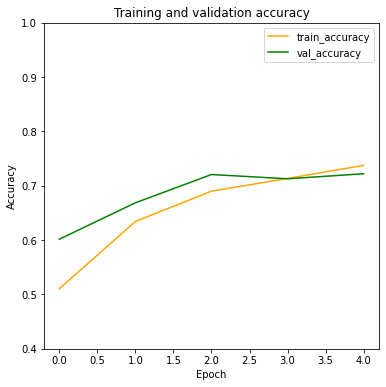

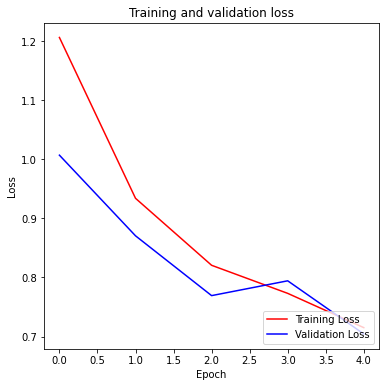

In [27]:
# Plotting the performance of the model over training
plt.figure(figsize=(6,6))
plt.plot(history.history['accuracy'],'orange', label = 'train_accuracy')
plt.plot(history.history['val_accuracy'], 'g', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0.4, 1])
plt.title('Training and validation accuracy')
plt.show()

plt.figure(figsize=(6,6))
plt.plot( history.history['loss'], 'r', label='Training Loss')
plt.plot( history.history['val_loss'], 'b', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.legend(loc = 'lower right')
plt.show()

In [28]:
# Applied the model to predict the unseen data
pred_generator = ImageDataGenerator(rescale = 1./255)
pred_generated = pred_generator.flow(X_pred, batch_size=32, shuffle = False)
y_pred = cnn.predict(pred_generated, batch_size=32)


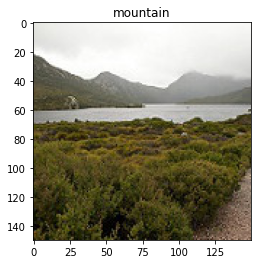

In [29]:
# Defining the function for predicting the unseen data
import PIL
from PIL import Image
from skimage import transform

def load_image(path):
  file_path = random.choice(gb.glob(pathname = path+'/*.jpg'))
  #image = Image.open(file_path)
  img = image.load_img(file_path, target_size=(150, 150))
  np_image = np.array(img).astype('float32')/255
  np_image = transform.resize(np_image, (64, 64, 3))
  np_image_exp = np.expand_dims(np_image, axis=0)
  return img,np_image_exp

encoded_labels_reverse = dict([(v, k) for k, v in encoded_labels.items()])
img = load_image(pred_path)
label=np.argmax(cnn.predict(img[1]), axis=-1)
plt.title(encoded_labels_reverse[int(label)])
plt.imshow(img[0])
plt.show()
   

# Building the model with the pre-trained learning

In [30]:
# Loading the VGG pre-trained model

from keras.applications import VGG16
vgg = VGG16(weights = 'imagenet',
            include_top = False,
            input_shape = (150,150,3))

58892288/58889256 [==============================] - 1s 0us/step




*   weights: innitial weights. We want to reuse the same weights as Imagenet
*   include_top: whether we want to use the tops levels of the model or not. We would not want to do that because we just have 6 classes compared to their 100 classes
* input_shape: image tensors' shapes for input into the network.


In [31]:
# Observe the architecture of the pretrained model
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [32]:
# Passing the data into the pretrained convolution base t extract features
## Copying generator, delete later on
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(rescale = 1./255,    
                                      shear_range = 0.2,
                                      rotation_range=20,
                                      zoom_range = 0.2,
                                      horizontal_flip = True)

# Defining a feature extraction function
def extracting_features(path):
  ## Setting the shape of features similar to the pretrained convolution base
  #features = np.zero(shape = (len(os.listdir(path),4,4, 512)))
  #labels = np.zero(shape = (len(os.listdir(path))))
  ## Pre-processing the  data with generator
  data_generated = train_generator.flow_from_directory(path, target_size = (150,150),
                                                       batch_size = 32,                                                   
                                                       class_mode = 'sparse')
  ## Passing data through the convolution base
  image_batch, label_batch = next(iter(data_generated))
  feature_batch = vgg(image_batch)
  return feature_batch, label_batch

# Applying the defined function to extract features on the training and the testing set
train_features, train_labels = extracting_features(train_path)
test_feature, test_labels = extracting_features(test_path)



Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [33]:
print(train_features.shape)
print(train_labels.shape)

(32, 4, 4, 512)
(32,)


In [34]:
# Building the model by adding neural network layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, MaxPooling2D, Flatten, Dropout

cnn_tf = Sequential()
cnn_tf.add(Flatten(input_shape = (4,4,512)))
cnn_tf.add(Dense(256, activation = 'relu'))#input_dim=(7*7*512)
cnn_tf.add(Dropout(0.5))
cnn_tf.add(Dense(6, activation = 'softmax'))
cnn_tf.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 6)                 1542      
Total params: 2,098,950
Trainable params: 2,098,950
Non-trainable params: 0
_________________________________________________________________


In [35]:
# Compiling the model
cnn_tf.compile(optimizer='adam', 
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics = 'accuracy')

# Fitting the model into the data for training
history = cnn_tf.fit(train_features,
                     train_labels, 
                     epochs = 5,
                     validation_split =0.2,
                     batch_size = 32)


Epoch 1/5
1/1 [==============================] - 0s 483ms/step - loss: 2.1131 - accuracy: 0.2000 - val_loss: 1.7714 - val_accuracy: 0.2857
Epoch 2/5
1/1 [==============================] - 0s 40ms/step - loss: 1.8734 - accuracy: 0.3200 - val_loss: 1.6993 - val_accuracy: 0.1429
Epoch 3/5
1/1 [==============================] - 0s 35ms/step - loss: 0.7881 - accuracy: 0.6800 - val_loss: 1.7971 - val_accuracy: 0.1429
Epoch 4/5
1/1 [==============================] - 0s 34ms/step - loss: 0.7148 - accuracy: 0.6800 - val_loss: 1.3649 - val_accuracy: 0.2857
Epoch 5/5
1/1 [==============================] - 0s 39ms/step - loss: 0.2837 - accuracy: 0.8800 - val_loss: 1.5108 - val_accuracy: 0.2857


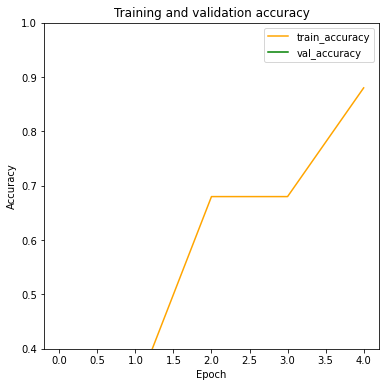

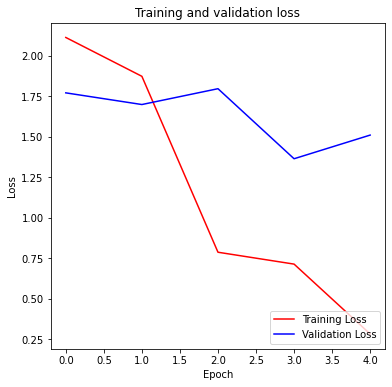

In [36]:
# Evaluating the model
# Plotting the performance of the model over training
plt.figure(figsize=(6,6))
plt.plot(history.history['accuracy'],'orange', label = 'train_accuracy')
plt.plot(history.history['val_accuracy'], 'g', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0.4, 1])
plt.title('Training and validation accuracy')
plt.show()

plt.figure(figsize=(6,6))
plt.plot( history.history['loss'], 'r', label='Training Loss')
plt.plot( history.history['val_loss'], 'b', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
## Applying the model to predict the unseen data
import PIL
from PIL import Image
from skimage import transform

def load_image(path):
  file_path = random.choice(gb.glob(pathname = path+'/*.jpg'))
  #image = Image.open(file_path)
  img = image.load_img(file_path, target_size=(150, 150))
  np_image = np.array(img).astype('float32')/255
  np_image = transform.resize(np_image, (150, 150, 3))
  np_image_exp = np.expand_dims(np_image, axis=0)
  return img,np_image_exp

encoded_labels_reverse = dict([(v, k) for k, v in encoded_labels.items()])
img = load_image(pred_path)
label=np.argmax(cnn_tf.predict(img[1]), axis=-1)
plt.title(encoded_labels_reverse[int(label)])
plt.imshow(img[0])
plt.show()

ValueError: ignored